# Python interfaces to output files of ParticleTrajectorySimulationsCore

これらの関数を使うためには以下のモジュールが必要です。
- [h5py](https://docs.h5py.org/en/stable/build.html#install)
- [numpy](https://numpy.org/install/)

[Anaconda](https://www.anaconda.com/)を使用している場合はすでにどちらもインストールされていると思います。

In [1]:
import h5py
import numpy as np

## number_of_trajectories

```python
int number_of_trajectories(file)
```

ParticleTrajectorySimulationsCoreのアウトプットファイルに記録された軌道の数を返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録された軌道の数を返す。
number_of_trajectories("result.h5")

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = number_of_trajectories(fid)
```

In [2]:
def number_of_trajectories(file):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return number_of_trajectories(fid)
    i = 0
    trajectories = file["trajectories"]
    while True:
        if f"{i+1}" not in trajectories:
            break
        i += 1
    return i

## number_of_recorded_points

```python
int number_of_recorded_points(file, i)
```

ParticleTrajectorySimulationsCoreのアウトプットファイルに記録される軌道はある時間における座標および速度の配列として表現されます。
`number_of_recorded_points` はインデックス `i` に指定される一つの軌道について、記録された座標の数を返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。
- i: *int*
    - 軌道を指定するインデックス。記録された軌道の数が *n* 個のとき、`i` は 0, 1, ..., (n-1)。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録された最初の軌道の座標点数を返す。
number_of_recorded_points("result.h5", 0)

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = number_of_recorded_points(fid, 0)
```

In [3]:
def number_of_recorded_points(file, i):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return number_of_recorded_points(fid, i)
    data = file[f"trajectories/{i+1}"]
    nrp = data.shape[0]
    del data
    return nrp

## collect_success_attribute

```python
numpy.ndarray collect_success_attribute(file, indices=None)
```

`indices` に指定される軌道に関しての成否の情報を真偽値の配列として返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。
- indices: *list of int*, optional
    - 軌道を指定するインデックス。各要素は記録された軌道の数が *N* 個のとき、0, 1, ..., (N-1) のどれかでなければならない。省略されたときはすべての軌道についての結果を返す。

### 帰り値
- out: *numpy.ndarray*
    - 1次元n要素の `numpy.ndarray` 配列、ただし *n* は取得した軌道の数。各要素は真偽値 (`True` or `False`)。

### 依存
- `number_of_trajectories` が定義されている必要がある。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録されたすべての軌道の成否を返す。
collect_success_attribute("result.h5")

# カレントディレクトリ上の result.h5 に記録された最初の３つの軌道の成否を返す。
collect_success_attribute("result.h5", [0, 1, 2])

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = collect_success_attribute(fid)
```

In [4]:
def collect_success_attribute(file, indices=None):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return collect_success_attribute(fid, indices)
    if indices is None:
        indices = range(number_of_trajectories(file))
    n = len(indices)
    success = np.zeros((n,), dtype=bool)
    for j, i in enumerate(indices):
        data = file[f"trajectories/{i+1}"]
        success[j] = data.attrs["success"] == 1
        del data
    return success

## collect_initial_points

```python
numpy.ndarray collect_initial_points(file, indices)
```

`indices` に指定される軌道の初期座標を配列として返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。
- indices: *list of int*, *numpy.ndarray of bool*, optional
    - 軌道を指定するインデックス。各要素は記録された軌道の数が *N* 個のとき、0, 1, ..., (N-1) のどれかでなければならない。あるいは真偽値の `numpy.ndarray` を受け取ることもできる。この場合は真値のインデックスに対応する軌道についてのみの結果を返す。これは例えば、`collect_success_attribute` の返り値を利用するのに便利である。省略されたときはすべての軌道についての結果を返す。
    
### 帰り値
- out: *numpy.ndarray*
    - 2次元(*n*, 7)要素の `numpy.ndarray` 配列、ただし *n* は取得した軌道の数。行の7要素はそれぞれ `[time, x, y, z, vx, vy, vz]`。
    
### 依存
- `number_of_trajectories` が定義されている必要がある。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録されたすべての軌道の初期座標を返す。
collect_initial_points("result.h5")

# カレントディレクトリ上の result.h5 に記録された最初の３つの軌道の初期座標を返す。
collect_initial_points("result.h5", [0, 1, 2])

# カレントディレクトリ上の result.h5 に記録された成功した軌道の初期座標を返す。
success = collect_success_attribute("result.h5")
collect_initial_points("result.h5", success)

# カレントディレクトリ上の result.h5 に記録された失敗した軌道の初期座標を返す。
success = collect_success_attribute("result.h5")
collect_initial_points("result.h5", ~success)

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = collect_initial_points(fid)
```

In [5]:
def collect_initial_points(file, indices=None):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return collect_initial_points(fid, indices)
    if indices is None:
        indices = range(number_of_trajectories(file))
    elif isinstance(indices, np.ndarray) and indices.dtype is np.dtype('bool'):
        indices = [i for i, b in enumerate(indices) if b]
    n = len(indices)
    points = np.zeros((n, 7))
    for j, i in enumerate(indices):
        data = file[f"trajectories/{i+1}"]
        points[j, :] = data[0, :]
        del data
    return points

## collect_end_points

```python
numpy.ndarray collect_end_points(file, indices)
```

`indices` に指定される軌道の終端座標を配列として返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。
- indices: *list of int*, *numpy.ndarray of bool*, optional
    - 軌道を指定するインデックス。各要素は記録された軌道の数が *N* 個のとき、0, 1, ..., (N-1) のどれかでなければならない。あるいは真偽値の `numpy.ndarray` を受け取ることもできる。この場合は真値のインデックスに対応する軌道についてのみの結果を返す。これは例えば、`collect_success_attribute` の返り値を利用するのに便利である。省略されたときはすべての軌道についての結果を返す。
    
### 帰り値
- out: *numpy.ndarray*
    - 2次元(*n*, 7)要素の `numpy.ndarray` 配列、ただし *n* は取得した軌道の数。行の7要素はそれぞれ `[time, x, y, z, vx, vy, vz]`。
    
### 依存
- `number_of_trajectories` が定義されている必要がある。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録されたすべての軌道の終端座標を返す。
collect_end_points("result.h5")

# カレントディレクトリ上の result.h5 に記録された最初の３つの軌道の終端座標を返す。
collect_end_points("result.h5", [0, 1, 2])

# カレントディレクトリ上の result.h5 に記録された成功した軌道の終端座標を返す。
success = collect_success_attribute("result.h5")
collect_end_points("result.h5", success)

# カレントディレクトリ上の result.h5 に記録された失敗した軌道の終端座標を返す。
success = collect_success_attribute("result.h5")
collect_end_points("result.h5", ~success)

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = collect_end_points(fid)
```

In [6]:
def collect_end_points(file, indices=None):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return collect_end_points(fid, indices)
    if indices is None:
        indices = range(number_of_trajectories(file))
    elif isinstance(indices, np.ndarray) and indices.dtype is np.dtype('bool'):
        indices = [i for i, b in enumerate(indices) if b]
    n = len(indices)
    points = np.zeros((n, 7))
    for j, i in enumerate(indices):
        data = file[f"trajectories/{i+1}"]
        points[j, :] = data[-1, :]
        del data
    return points

## collect_trajectories

```python
list collect_end_points(file, indices)
```

`indices` に指定される軌道の終端座標を配列として返します。

### 引数
- file: *str*, *h5py.File*
    - アウトプットファイルへのファイルパス。あるいは `h5py.File` オブジェクト。
- indices: *list of int*, optional
    - 軌道を指定するインデックス。各要素は記録された軌道の数が *N* 個のとき、0, 1, ..., (N-1) のどれかでなければならない。あるいは真偽値の `numpy.ndarray` を受け取ることもできる。この場合は真値のインデックスに対応する軌道についてのみの結果を返す。これは例えば、`collect_success_attribute` の返り値を利用するのに便利である。省略されたときはすべての軌道についての結果を返す。

### 帰り値
- out: *list of numpy.ndarray*
    - *n* 個の *numpy.ndarray* のリストであり、各要素は2次元(*m*, 7)要素の `numpy.ndarray` 配列。ただし、ここで *n* は取得した軌道の数、*m* は軌道の記録座標点数。*m* は各軌道ごとに異なるかもしれない。軌道の行の7要素はそれぞれ `[time, x, y, z, vx, vy, vz]`

### 依存
- `number_of_trajectories` が定義されている必要がある。

### 使用例
```python
# カレントディレクトリ上の result.h5 に記録されたすべての軌道を返す。
collect_trajectories("result.h5")

# カレントディレクトリ上の result.h5 に記録された最初の３つの軌道を返す。
collect_trajectories("result.h5", [0, 1, 2])

# カレントディレクトリ上の result.h5 に記録された成功した軌道を返す。
success = collect_success_attribute("result.h5")
collect_trajectories("result.h5", success)

# カレントディレクトリ上の result.h5 に記録された失敗した軌道を返す。
success = collect_success_attribute("result.h5")
collect_trajectories("result.h5", ~success)

# ファイルパスの代わりに h5py.File オブジェクトを受け付ける
with h5py.File("result.h5", 'r') as fid:
    out = collect_trajectories(fid)
```

In [7]:
def collect_trajectories(file, indices=None):
    if not isinstance(file, h5py.File):
        with h5py.File(file, 'r') as fid:
            return collect_trajectories(fid, indices)
    if indices is None:
        indices = range(number_of_trajectories(file))
    elif isinstance(indices, np.ndarray) and indices.dtype is np.dtype('bool'):
        indices = [i for i, b in enumerate(indices) if b]
    n = len(indices)
    trajectories = []
    for j, i in enumerate(indices):
        data = file[f"trajectories/{i+1}"]
        m = data.shape[0]
        traj = np.zeros((m, 7))
        traj[:, :] = data[:, :]
        trajectories.append(traj)
        del data
    return trajectories

## 使用例

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

### すべての軌道をプロットする

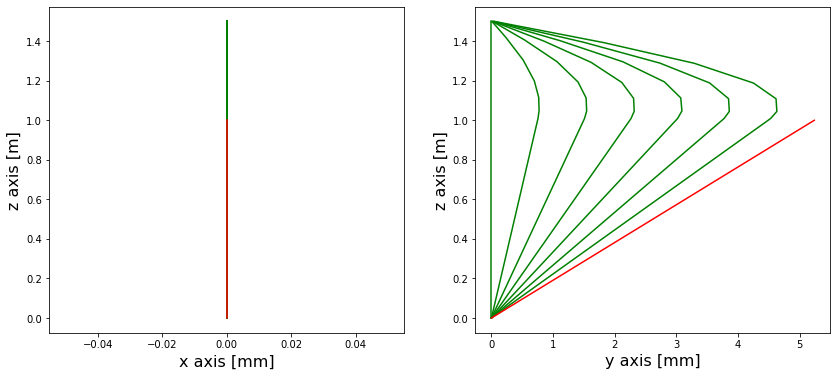

In [9]:
outputfile = "result.h5"
success = collect_success_attribute(outputfile)
trajectories = collect_trajectories(outputfile)
fig = plt.figure(figsize=(14, 6))
ax_xz = fig.add_subplot(1, 2, 1)
ax_yz = fig.add_subplot(1, 2, 2)
for s, traj in zip(success, trajectories):
    x = traj[:, 1]
    y = traj[:, 2]
    z = traj[:, 3]
    c = "g" if s else "r"
    ax_xz.plot(x*1e3, z, c)
    ax_yz.plot(y*1e3, z, c)
ax_xz.set_xlabel("x axis [mm]", fontsize=16)
ax_xz.set_ylabel("z axis [m]", fontsize=16)
ax_yz.set_xlabel("y axis [mm]", fontsize=16)
ax_yz.set_ylabel("z axis [m]", fontsize=16);

### 終端座標をx-y平面にプロットする

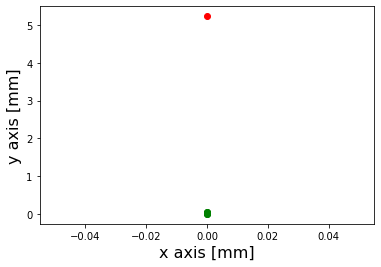

In [10]:
success = collect_success_attribute(outputfile)
p_success = collect_end_points(outputfile, success)
p_failed = collect_end_points(outputfile, ~success)

x_success = p_success[:, 1]
y_success = p_success[:, 2]
x_failed = p_failed[:, 1]
y_failed = p_failed[:, 2]
plt.scatter(x_success*1e3, y_success*1e3, c="g")
plt.scatter(x_failed*1e3, y_failed*1e3, c="r")
plt.xlabel("x axis [mm]", fontsize=16)
plt.ylabel("y axis [mm]", fontsize=16);